In [4]:
import os
import json
import glob
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [7]:
base_log_dir = Path("../../yaib_logs")

In [2]:
hospital_ids = [73, 264, 420, 243, 338, 443, 199, 458, 300, 188, 252, 167]
hospital_dict = {} 
for i in range(len(hospital_ids)):
    hospital_dict[hospital_ids[i]] = i

## Section 1: Sequential n for two hospitals 199 and 443

- 2 hospitals x 3 models x 3 metrics
- {199, 443} x {'LSTM', 'LogisticRegression', 'LGBMClassifier'} x {avg, std, ci}

In [3]:
for model in ['LSTM', 'LogisticRegression', 'LGBMClassifier']: 
    log_dir = base_log_dir /  f'eicu/Mortality24/{model}'
    avg_dict = {} 
    std_dict = {} 
    ci_dict = {} 
    hos = 443
    for n in [400, 800, 1000, 1200, 1500, 2000]: 
        dir_str = f"train-test{hos}-n{n}"
        exp_dir = os.path.join(log_dir, dir_str)
        files = os.listdir(exp_dir)
        # folders only 
        files = [name for name in files if os.path.isdir(os.path.join(exp_dir, name)) and not name.startswith('.')]
        paths = [os.path.join(exp_dir, basename) for basename in files]
        target_dir = max(paths, key=os.path.getctime)
    
        f = open(os.path.join(target_dir, 'accumulated_test_metrics.json'))
        result_dict = json.load(f)
        for keyword, key_dict in zip(['avg', 'std'], [avg_dict, std_dict]): 
            key_results = result_dict[keyword]
            for key in key_results.keys(): 
                if key not in key_dict.keys(): 
                    key_dict[key] = {}
                key_dict[key][n] = key_results[key]
        ci = result_dict['CI_0.95']
        for key in ci.keys(): 
            if key not in ci_dict.keys(): 
                ci_dict[key] = ({}, {})
            ci_dict[key][0][n] = ci[key][0]
            ci_dict[key][1][n] = ci[key][1]
    
    np.savez(f"results/sequential-n/{hos}-{model}-avg.npz", **avg_dict)
    np.savez(f"results/sequential-n/{hos}-{model}-std.npz", **std_dict)
    np.savez(f"results/sequential-n/{hos}-{model}-ci.npz", **ci_dict)

In [8]:
model = 'LogisticRegression'
log_dir = base_log_dir / f'eicu/Mortality24/{model}'
avg_dict = {} 
std_dict = {} 
ci_dict = {} 
n_1500 = True
for i, train_hos in enumerate(hospital_ids): 
    for j, test_hos in enumerate(hospital_ids): 
            if j > i: 
                dir_str = f"train{train_hos}-{test_hos}"
            
                exp_dir = os.path.join(log_dir, dir_str)
                if model == 'LSTM' and i != j: 
                    exp_dir = os.path.join(exp_dir, '_from_eicu')
                files = os.listdir(exp_dir)
                # folders only 
                files = [name for name in files if os.path.isdir(os.path.join(exp_dir, name)) and not name.startswith('.')]
                paths = [os.path.join(exp_dir, basename) for basename in files]
                target_dir = max(paths, key=os.path.getctime)
        
                f = open(os.path.join(target_dir, 'accumulated_test_metrics.json'))
                result_dict = json.load(f)
                for keyword, key_dict in zip(['avg', 'std'], [avg_dict, std_dict]): 
                    key_results = result_dict[keyword]
                    for key in key_results.keys(): 
                        if key not in key_dict.keys(): 
                            key_dict[key] = np.zeros((n, n))
            
                        key_dict[key][i, j] = key_results[key]
                ci = result_dict['CI_0.95']
                for key in ci.keys(): 
                    if key not in ci_dict.keys(): 
                        ci_dict[key] = (np.zeros((n, n)), np.zeros((n, n)))
                    ci_dict[key][0][i, j] = ci[key][0]
                    ci_dict[key][1][i, j] = ci[key][1]


np.savez(f"results/joint-dist/{model}-avg.npz", **avg_dict)
np.savez(f"results/joint-dist/{model}-std.npz", **std_dict)
np.savez(f"results/joint-dist/{model}-ci.npz", **ci_dict)

## Section 2: Distribution Shift Data

here we load 6 models: 
- LSTM (all, n1500) 
- LogisticRegression (all, n1500)
- LGBMClassifier (all, n1500)
  
for each model we have 4 files: 
- results/dist_shift/{model}-n1500-avg.npz
- results/dist_shift/{model}-n1500-std.npz
- results/dist_shift/{model}-n1500-ci.npz
- results/dist_shift/{model}-AUC-n1500-diff-avg.npz

In [4]:
model = 'LogisticRegression'
log_dir = base_log_dir /  f'eicu/Mortality24/{model}'
avg_dict = {} 
std_dict = {} 
ci_dict = {} 
n_1500 = True
for i, train_hos in enumerate(hospital_ids): 
    for j, test_hos in enumerate(hospital_ids): 
        if n_1500: 
            if i == j: 
                dir_str = f"train-test{test_hos}-n1500"
            else: 
                dir_str = f"train{train_hos}-test{test_hos}-n1500"
        else:     
            dir_str = f"train{train_hos}-test{test_hos}"
        
        exp_dir = os.path.join(log_dir, dir_str)
        if model == 'LSTM' and i != j: 
            exp_dir = os.path.join(exp_dir, '_from_eicu')
        files = os.listdir(exp_dir)
        # folders only 
        files = [name for name in files if os.path.isdir(os.path.join(exp_dir, name)) and not name.startswith('.')]
        paths = [os.path.join(exp_dir, basename) for basename in files]
        target_dir = max(paths, key=os.path.getctime)

        f = open(os.path.join(target_dir, 'accumulated_test_metrics.json'))
        result_dict = json.load(f)
        for keyword, key_dict in zip(['avg', 'std'], [avg_dict, std_dict]): 
            key_results = result_dict[keyword]
            for key in key_results.keys(): 
                if key not in key_dict.keys(): 
                    key_dict[key] = np.zeros((n, n))
    
                key_dict[key][i, j] = key_results[key]
        ci = result_dict['CI_0.95']
        for key in ci.keys(): 
            if key not in ci_dict.keys(): 
                ci_dict[key] = (np.zeros((n, n)), np.zeros((n, n)))
            ci_dict[key][0][i, j] = ci[key][0]
            ci_dict[key][1][i, j] = ci[key][1]

# saving results
if n_1500: 
    np.savez(f"results/dist_shift/{model}-n1500-avg.npz", **avg_dict)
    np.savez(f"results/dist_shift/{model}-n1500-std.npz", **std_dict)
    np.savez(f"results/dist_shift/{model}-n1500-ci.npz", **ci_dict)
else: 
    np.savez(f"results/dist_shift/{model}-avg.npz", **avg_dict)
    np.savez(f"results/dist_shift/{model}-std.npz", **std_dict)
    np.savez(f"results/dist_shift/{model}-ci.npz", **ci_dict)

In [ ]:
metric = 'AUC'
fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)

sns.heatmap(avg_dict[metric], annot=True, cmap="rocket_r", ax=axes[0], 
                      xticklabels=hospital_ids, 
           yticklabels=hospital_ids,)
axes[0].set_xlabel("Test Hospital")
axes[0].set_ylabel("Train Hospital")
axes[0].set_title("Mean")


CI = ci_dict[metric][1] - avg_dict[metric]
sns.heatmap(CI, fmt=".2e", annot_kws={'fontsize':7}, cmap="rocket_r", 
                      xticklabels=hospital_ids, 
           yticklabels=hospital_ids,)
axes[1].set_xlabel("Test Hospital")
axes[1].set_ylabel("Train Hospital")
axes[1].set_title("95% CI")

plt.suptitle(f"{model} Train-Test {metric} drop across hospitals")

Text(0.5, 1.0, 'LSTM AUC Change Between Train and Test Hospitals')

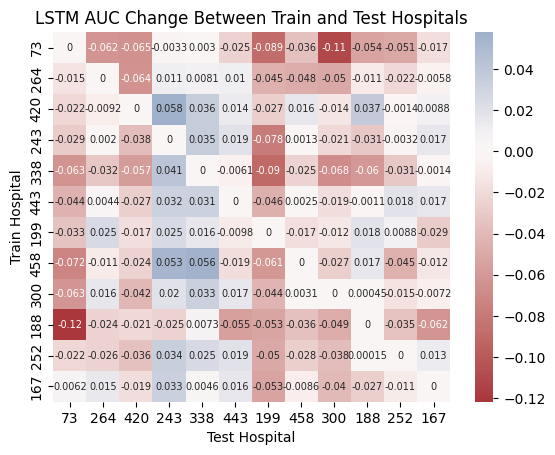

In [18]:
# Differences
diff = avg_dict[metric] - np.repeat(np.diagonal(avg_dict[metric]).reshape(-1, 1), len(hospital_ids), axis=1).T
if n_1500: 
    np.savez(f'results/dist_shift/{model}-{metric}-n1500-diff-avg.npz', **{f'{metric}':diff})
else: 
    np.savez(f'results/dist_shift/{model}-{metric}-diff-avg.npz', **{f'{metric}':diff})
sns.heatmap(diff, annot=True, 
            annot_kws={'fontsize':7}, cmap="vlag_r", 
           xticklabels=hospital_ids, 
           yticklabels=hospital_ids,
           center=0)
plt.xlabel("Test Hospital")
plt.ylabel("Train Hospital")
plt.title(f"{model} {metric} Change Between Train and Test Hospitals")

## Section 3: Addition of Data

- {all, n1500} x {LSTM, LogisticRegression, LGBMClassifier} x {avg, std, ci, diff-AUC-avg}

In [6]:
model = 'LSTM'
log_dir = base_log_dir /  f'eicu/Mortality24/{model}'
avg_dict = {} 
std_dict = {} 
ci_dict = {} 
n_1500 = True
for i, train_hos in enumerate(hospital_ids): 
    for j, test_hos in enumerate(hospital_ids): 
        if i != j: 
            if n_1500: 
                dir_str = f"train{train_hos}-{test_hos}-test{test_hos}-n1500"
            else: 
                dir_str = f"train{train_hos}-{test_hos}-test{test_hos}"
            exp_dir = os.path.join(log_dir, dir_str)
            files = os.listdir(exp_dir)
            files.sort()
            datetime = files[-1]
            f = open(os.path.join(exp_dir, datetime, 'accumulated_test_metrics.json'))
            result_dict = json.load(f)
            for keyword, key_dict in zip(['avg', 'std'], [avg_dict, std_dict]): 
                key_results = result_dict[keyword]
                for key in key_results.keys(): 
                    if key not in key_dict.keys(): 
                        key_dict[key] = np.zeros((len(hospital_ids), len(hospital_ids)))
        
                    key_dict[key][i, j] = key_results[key]
            ci = result_dict['CI_0.95']
            for key in ci.keys(): 
                if key not in ci_dict.keys(): 
                    ci_dict[key] = (np.zeros((len(hospital_ids), len(hospital_ids))), 
                                    np.zeros((len(hospital_ids), len(hospital_ids))))
                ci_dict[key][0][i, j] = ci[key][0]
                ci_dict[key][1][i, j] = ci[key][1]

if n_1500: 
    np.savez(f"results/add_data/{model}-n1500-avg.npz", **avg_dict)
    np.savez(f"results/add_data/{model}-n1500-std.npz", **std_dict)
    np.savez(f"results/add_data/{model}-n1500-ci.npz", **ci_dict)
else: 
    np.savez(f"results/add_data/{model}-avg.npz", **avg_dict)
    np.savez(f"results/add_data/{model}-std.npz", **std_dict)
    np.savez(f"results/add_data/{model}-ci.npz", **ci_dict)

Text(0.5, 0.98, 'LSTM Train-Test AUC drop across hospitals')

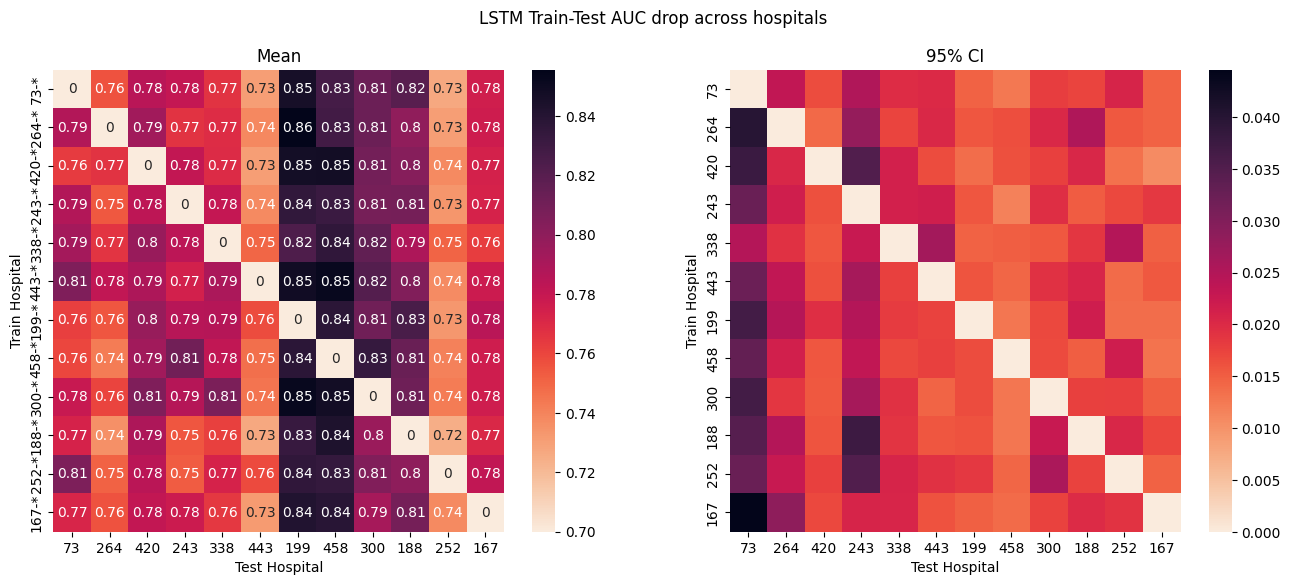

In [7]:
metric = 'AUC'
fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
train_test_ids = [f"{h}-*" for h in hospital_ids]

plot_mat = avg_dict[metric] #+ np.diagonal(dist_shift_avg[metric])*np.eye(len(hospital_ids)) 
           
sns.heatmap(plot_mat, annot=True, cmap="rocket_r", ax=axes[0], 
            xticklabels=hospital_ids, 
           yticklabels=train_test_ids, 
           vmin=0.7)
axes[0].set_xlabel("Test Hospital")
axes[0].set_ylabel("Train Hospital")
axes[0].set_title("Mean")


CI = ci_dict[metric][1] - avg_dict[metric]
sns.heatmap(CI, fmt=".2e", annot_kws={'fontsize':7}, cmap="rocket_r", 
                      xticklabels=hospital_ids, 
           yticklabels=hospital_ids,)
axes[1].set_xlabel("Test Hospital")
axes[1].set_ylabel("Train Hospital")
axes[1].set_title("95% CI")

plt.suptitle(f"{model} Train-Test {metric} drop across hospitals")

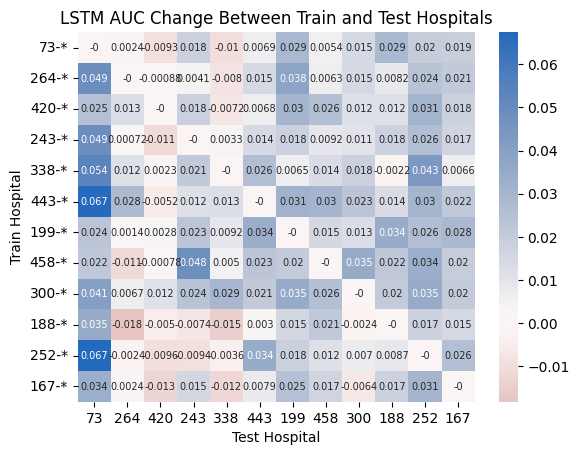

In [8]:
dist_shift_avg = np.load(f"results/dist_shift/{model}-avg.npz")
addition_diff = plot_mat - np.repeat(np.diagonal(dist_shift_avg[metric]).reshape(-1, 1), len(hospital_ids), axis=1).T
addition_diff = addition_diff*(1-np.eye(len(addition_diff)))
sns.heatmap(addition_diff, annot=True, 
            annot_kws={'fontsize':7}, cmap="vlag_r", 
           xticklabels=hospital_ids, 
           yticklabels=train_test_ids,
           center=0)
plt.xlabel("Test Hospital")
plt.ylabel("Train Hospital")
plt.title(f"{model} {metric} Change Between Train and Test Hospitals")

if n_1500: 
    with open(f"results/add_data/{model}-AUC-n1500-diff-avg.npy", "wb") as f: 
        np.save(f, addition_diff)
else: 
    with open(f"results/add_data/{model}-AUC-diff-avg.npy", "wb") as f: 
        np.save(f, addition_diff)

## Section 4: Sequential and Mixture Addition

In [17]:
test_hos = '443'
file_n = 1000 
KL = True
if test_hos == '443': 
    if KL: 
        train_hos_best = [('443-458', 2*file_n), 
                      ('443-458-167', 3*file_n),
                      ('443-458-167-300', 4*file_n)]
        train_hos_worst = [
                          ('443-73', 2*file_n), 
                          ('443-73-252', 3*file_n),
                          ('443-73-252-338', 4*file_n)]
    else: 
        train_hos_best = [
                      ('443-458', 3000), 
                      ('443-458-420', 4500),
                      ('443-458-420-300', 6000)]
        train_hos_worst = [
                          ('443-73', 3000), 
                          ('443-73-188', 4500),
                          ('443-73-188-167', 6000)]
if test_hos == '199': 
    train_hos_best = [
                    ('300-199', 3000), 
                  ('199-300-458', 4500),
                  ('199-300-458-167', 6000)]
    train_hos_worst = [
                  ('73-199', 3000), 
                  ('199-73-252', 4500),
                  ('199-73-252-443', 6000)]

In [20]:

train_list = [('best-hospitals', train_hos_best), 
             ('worst-hospitals', train_hos_worst)]
avg_dict = {} 
std_dict = {} 
ci_dict = {} 
model = 'LogisticRegression'
log_dir = base_log_dir /  f'eicu/Mortality24/{model}'
for hos_group, train_group in train_list: 
    for train_hos, n_train in train_group: 
        dir_str = f"train{train_hos}-test{test_hos}-n{file_n}"
        exp_dir = os.path.join(log_dir, dir_str)
        files = os.listdir(exp_dir)
    
        files = [name for name in files if os.path.isdir(os.path.join(exp_dir, name)) and not name.startswith('.')]
        paths = [os.path.join(exp_dir, basename) for basename in files]
        target_dir = max(paths, key=os.path.getctime)
    
        f = open(os.path.join(target_dir, 'accumulated_test_metrics.json'))
        result_dict = json.load(f)
        for keyword, key_dict in zip(['avg', 'std'], [avg_dict, std_dict]): 
            key_results = result_dict[keyword]
            for key in key_results.keys(): 
                if key not in key_dict.keys(): 
                    key_dict[key] = {}
                key_dict[key][n_train] = key_results[key]
        ci = result_dict['CI_0.95']
        for key in ci.keys(): 
            if key not in ci_dict.keys(): 
                ci_dict[key] = ({}, {})
            ci_dict[key][0][n_train] = ci[key][0]
            ci_dict[key][1][n_train] = ci[key][1]
    if KL: 
        np.savez(f"results/sequential-n{file_n}/{test_hos}/{test_hos}-{model}-{hos_group}-avg.npz", **avg_dict)
        np.savez(f"results/sequential-n{file_n}/{test_hos}/{test_hos}-{model}-{hos_group}-std.npz", **std_dict)
        np.savez(f"results/sequential-n{file_n}/{test_hos}/{test_hos}-{model}-{hos_group}-ci.npz", **ci_dict)
    else: 
        np.savez(f"results/sequential-n{file_n}/{test_hos}/{test_hos}-{model}-{hos_group}-gt-avg.npz", **avg_dict)
        np.savez(f"results/sequential-n{file_n}/{test_hos}/{test_hos}-{model}-{hos_group}-gt-std.npz", **std_dict)
        np.savez(f"results/sequential-n{file_n}/{test_hos}/{test_hos}-{model}-{hos_group}-gt-ci.npz", **ci_dict)

In [21]:
log_dir = base_log_dir /  f'eicu/Mortality24/{model}'avg_dict = {} 
std_dict = {} 
ci_dict = {} 
hos = 443
#for n in [3000, 4500, 6000]: 
#for n in [2400, 3600, 4800]:
for n in [2000, 3000, 4000]:
    dir_str = f"train443-74-264-420-243-338-199-458-300-188-252-167-test{hos}-n{n}"
    exp_dir = os.path.join(log_dir, dir_str)
    files = os.listdir(exp_dir)
    # folders only 
    files = [name for name in files if os.path.isdir(os.path.join(exp_dir, name)) and not name.startswith('.')]
    paths = [os.path.join(exp_dir, basename) for basename in files]
    target_dir = max(paths, key=os.path.getctime)

    f = open(os.path.join(target_dir, 'accumulated_test_metrics.json'))
    result_dict = json.load(f)
    for keyword, key_dict in zip(['avg', 'std'], [avg_dict, std_dict]): 
        key_results = result_dict[keyword]
        for key in key_results.keys(): 
            if key not in key_dict.keys(): 
                key_dict[key] = {}
            key_dict[key][n] = key_results[key]
    ci = result_dict['CI_0.95']
    for key in ci.keys(): 
        if key not in ci_dict.keys(): 
            ci_dict[key] = ({}, {})
        ci_dict[key][0][n] = ci[key][0]
        ci_dict[key][1][n] = ci[key][1]

np.savez(f"results/sequential-n{file_n}/{hos}/{hos}-mixture-{model}-avg.npz", **avg_dict)
np.savez(f"results/sequential-n{file_n}/{hos}/{hos}-mixture-{model}-std.npz", **std_dict)
np.savez(f"results/sequential-n{file_n}/{hos}/{hos}-mixture-{model}-ci.npz", **ci_dict)